<div>
    <h2> Network Intrusion Detection using Linear Models, GBDT Ensembles and Deep Learning - A comparative study using state-of-the-art tools and libraries </h2>
    <p> In this study, we use the <a href='https://www.unb.ca/cic/datasets/nsl.html'>NSL KDD dataset</a> to predict the probability of occurence of 23 different classes of attacks on a network. Here, we use three different categories of models - Linear Models including Logistic Regression and Stochastic Gradient Descent (SGD) classifier; Gradient Boosting Decision Tree emsembles including LightGBM (LGBM) and XGBoost; and a Deep Neural Network (DNN) classifier. We also train a stacked model consisting of all these models as base learners. Finally, we compare the performances of all the models for Network Intrusion Detection using the NSL-KDD dataset and draw useful conclusions.</p>
</div>

In [1]:
# import required packages

import pandas as pd 
import numpy as np
import math, os, re, gc, time, warnings
from tqdm import tqdm

from entropy_calculator import ddosDetection
from scapy.all import *
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

from numpy import array
from keras.models import Sequential
from keras.layers import Dense, LSTM,  Embedding




import tensorflow as tf


%matplotlib inline

# settings
os.environ['OMP_NUM_THREADS'] = '4'
start_time = time.time()


warnings.filterwarnings("ignore")

pd.set_option('display.max_row', 100)
pd.set_option('display.max_columns', 100)

data = pd.read_csv('god4.csv')

#기존 오브제특 형태인 ip address 를 제거, 나머지 데이터 라벨 인코더
encoder = LabelEncoder()

# 기존 포트 번호를 라벨링으로 생성
en_col=['Source Port' , 'Destination Port', 'Protocol','Source IP', 'Destination IP', 'len_Separation_128']
for i in en_col:
    data[i] = encoder.fit_transform(data[i])
    

TH=0.5
    

def IDS(a,b,c):
    
    aa=np.float_(a.sumEntropy_history[-1:])
    bb=np.float_(b.sumEntropy_history[-1:])
    cc=np.float_(c.sumEntropy_history[-1:])
    
    a_mean=np.mean(a.sumEntropy_history)
    b_mean=np.mean(b.sumEntropy_history)
    c_mean=np.mean(c.sumEntropy_history)
    
    a_max=a_mean+TH
    b_max=b_mean+TH
    c_max=c_mean+TH
    
    a_min=(0 if a_mean-TH<=0 else a_mean-TH)
    b_min=(0 if b_mean-TH<=0 else b_mean-TH)
    c_min=(0 if c_mean-TH<=0 else c_mean-TH)

    #print(a_min,aa,a_max)
    if (a_min>aa) or (aa>a_max):
        #print('1')
        if (b_min>bb) or (bb>b_max):
            print('2')
            if (c_min>cc) or (cc>c_max):
                print('3')
                return 1
    else:
        return 0

entropy_SP_store=[]
entropy_DP_store=[]
entropy_SIP_store=[]
entropy_DIP_store=[]
entropy_LEN_store=[]

DIP = ddosDetection()
SIP = ddosDetection()
DP = ddosDetection()
SP = ddosDetection()
LEN=ddosDetection()

data["SP"] = np.nan
data["DP"] = np.nan
data["LEN"] = np.nan


Win_size=100

for i in tqdm(range(0,len(data))):
    #SIP.addinfo(data['Source IP'][i])
    #DIP.addinfo(data['Destination IP'][i])
    SP.addinfo(data['Source Port'][i])
    DP.addinfo(data['Destination Port'][i])
    LEN.addinfo(data['len_Separation_128'][i])
    
    #print(data['Source IP'][i])

    if i % Win_size == 0:
        #SIP.calculateEntropy()
        #DIP.calculateEntropy()
        SP.calculateEntropy()
        DP.calculateEntropy()
        LEN.calculateEntropy()
        
        
        #entropy_SIP_store.append(SIP.sumEntropy_history[-1:])
        #entropy_DIP_store.append(DIP.sumEntropy_history[-1:]) 
        entropy_SP_store.extend(SP.sumEntropy_history[-1:])
        entropy_DP_store.extend(DP.sumEntropy_history[-1:]) 
        entropy_LEN_store.extend(LEN.sumEntropy_history[-1:]) 
        
        #data.append(SP.sumEntropy_history[-1:])
        #data.append(DP.sumEntropy_history[-1:]) 
        #data.append(LEN.sumEntropy_history[-1:]) 
        
        if IDS(LEN,SP,DP)==1:
            print(i)

SP_shift=pd.DataFrame()
SP_shift['SP']=entropy_SP_store

DP_shift=pd.DataFrame()
DP_shift['DP']=entropy_DP_store

LEN_shift=pd.DataFrame()
LEN_shift['LEN']=entropy_LEN_store

SP_shift.to_csv('SP.csv',index=False)
DP_shift.to_csv('DP.csv',index=False)
LEN_shift.to_csv('LEN.csv',index=False)

In [2]:
LEN_shift = pd.read_csv('LEN.csv')
SP_shift = pd.read_csv('LEN.csv')
DP_shift = pd.read_csv('LEN.csv')

In [3]:
for s in range(1, 4):
    #SP_shift['shift_{}'.format(s)] = SP_shift['SP'].shift(s)
    #DP_shift['shift_{}'.format(s)] = DP_shift['DP'].shift(s)
    LEN_shift['shift_{}'.format(s)] = LEN_shift['LEN'].shift(s)
   
#SP_shift=SP_shift.fillna(method='bfill') # 빈 데이터 채우기   
#DP_shift=DP_shift.fillna(method='bfill') # 빈 데이터 채우기
LEN_shift=LEN_shift.fillna(method='bfill') # 빈 데이터 채우기

#SP_shift['max']=SP_shift.max(axis=1)
#SP_shift['min']=SP_shift.min(axis=1)

#DP_shift['max']=DP_shift.max(axis=1)
#DP_shift['min']=DP_shift.min(axis=1)

LEN_shift['max']=LEN_shift.max(axis=1)
LEN_shift['min']=LEN_shift.min(axis=1)

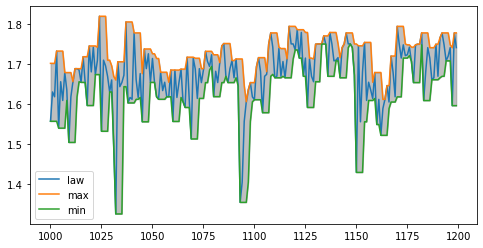

In [4]:
plt.figure(figsize=(8,4))

plt_len1=1000
plt_len2=1200

a=LEN_shift['LEN'][plt_len1:plt_len2]
b=LEN_shift['max'][plt_len1:plt_len2]
c=LEN_shift['min'][plt_len1:plt_len2]

x=list(range(len(LEN_shift)))
x_len=x[plt_len1:plt_len2]

plt.plot(a, label='law')
plt.plot(b, label='max')
plt.plot(c, label='min')

# 영역 채우기
plt.fill_between(x_len, b, c, color='gray', alpha=0.5)

# 범례 표시
plt.legend()
plt.show()

In [5]:
LEN_shift['dif']=LEN_shift['max']-LEN_shift['min']
#max min 값을 빼서 
LEN_shift['dif']=LEN_shift['dif']*0.5

LEN_shift['max']=LEN_shift['max']+LEN_shift['dif']
LEN_shift['min']=LEN_shift['min']-LEN_shift['dif']




In [6]:
LEN_shift[LEN_shift['min']<1]=1
LEN_shift

,LEN,shift_1,shift_2,shift_3,max,min,dif
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,1.816000,1.668554,1.379688,1.879512,2.129424,1.129775,0.249912
...,...,...,...,...,...,...,...
10481,1.697322,1.682461,1.653450,1.588662,1.751651,1.534332,0.054330
10482,1.653450,1.697322,1.682461,1.653450,1.719257,1.631514,0.021936
10483,1.617928,1.653450,1.697322,1.682461,1.737018,1.578232,0.039697
10484,1.586007,1.617928,1.653450,1.697322,1.752979,1.530350,0.055657


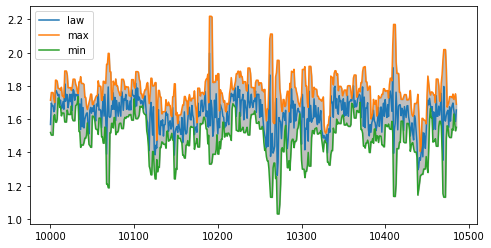

In [7]:
plt.figure(figsize=(8,4))

plt_len1=10000
plt_len2=11000

a=LEN_shift['LEN'][plt_len1:plt_len2]
b=LEN_shift['max'][plt_len1:plt_len2]
c=LEN_shift['min'][plt_len1:plt_len2]

x=list(range(len(LEN_shift)))
x_len=x[plt_len1:plt_len2]

plt.plot(a, label='law')
plt.plot(b, label='max')
plt.plot(c, label='min')

# 영역 채우기
plt.fill_between(x_len, b, c, color='gray', alpha=0.5)

# 범례 표시
plt.legend()
plt.show()

In [8]:
x=LEN_shift.iloc[:,1:4] # ex) shift 를 3개 밀면 4로
y=LEN_shift.iloc[:, [4,5]] #0, 5,6  /1
en=LEN_shift.iloc[:, [0]] #0

x_train, x_valid, y_train, y_valid = train_test_split(x, y, train_size = 0.8, shuffle=False)
en_train, en_valid= train_test_split(en, train_size = 0.8, shuffle=False)

en_train=en_train.reset_index(drop=True)
en_valid=en_valid.reset_index(drop=True)

r_x_train = np.array(x_train).reshape((x_train.shape[0], x_train.shape[1], 1))
r_y_train = np.array(y_train).reshape((y_train.shape[0], y_train.shape[1], 1))

r_x_valid = np.array(x_valid).reshape((x_valid.shape[0], x_valid.shape[1], 1))
r_y_valid = np.array(y_valid).reshape((y_valid.shape[0], y_valid.shape[1], 1))

x=i.iloc[:,1:4]
y=i.iloc[:, [4,5]] #0, 5,6  /1
en=i.iloc[:, [0]] #0, 5,6

x_train, x_valid, y_train, y_valid = train_test_split(x, y, train_size = 0.8, shuffle=False)
en_train, en_valid= train_test_split(en, train_size = 0.8, shuffle=False)

en_train=en_train.reset_index(drop=True)
en_valid=en_valid.reset_index(drop=True)

r_x_train = np.array(x_train).reshape((x_train.shape[0], x_train.shape[1], 1))
r_y_train = np.array(y_train).reshape((y_train.shape[0], y_train.shape[1], 1))

r_x_valid = np.array(x_valid).reshape((x_valid.shape[0], x_valid.shape[1], 1))
r_y_valid = np.array(y_valid).reshape((y_valid.shape[0], y_valid.shape[1], 1))

In [9]:
def lstm():
    model = Sequential()
    model.add(LSTM(3, activation = 'relu', input_shape=(4,1)))
    model.add(Dense(6))
    model.add(Dense(2)) # 2개 뽑으려면 2
    model.compile(optimizer='adam', loss='mse')

    return model

model=lstm()


Epoch 1 / 20
[[-0.12768702 -0.16691585]
 [-0.12480608 -0.16368823]
 [-0.12518801 -0.16453035]
 ...
 [-0.12622541 -0.16761678]
 [-0.12634237 -0.16643944]
 [-0.1254228  -0.16526458]]


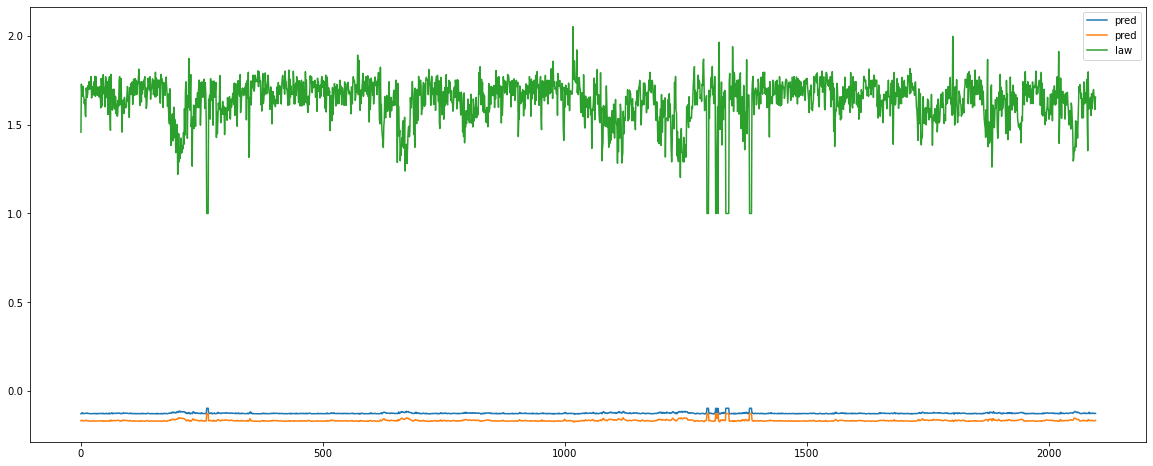

Epoch 2 / 20
[[-0.09278469 -0.12748288]
 [-0.09038158 -0.12479603]
 [-0.09067123 -0.12546556]
 ...
 [-0.0914799  -0.12818122]
 [-0.09163037 -0.12713839]
 [-0.09086844 -0.12614559]]


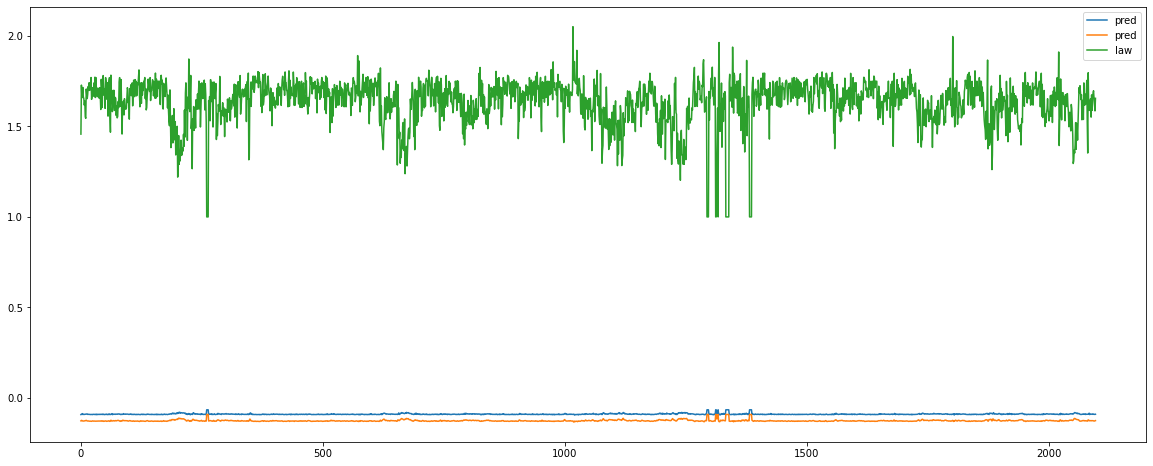

Epoch 3 / 20
[[-0.06104595 -0.09268022]
 [-0.05904825 -0.0904282 ]
 [-0.05927249 -0.09096234]
 ...
 [-0.05987557 -0.09335916]
 [-0.06005491 -0.09243412]
 [-0.05942892 -0.09158961]]


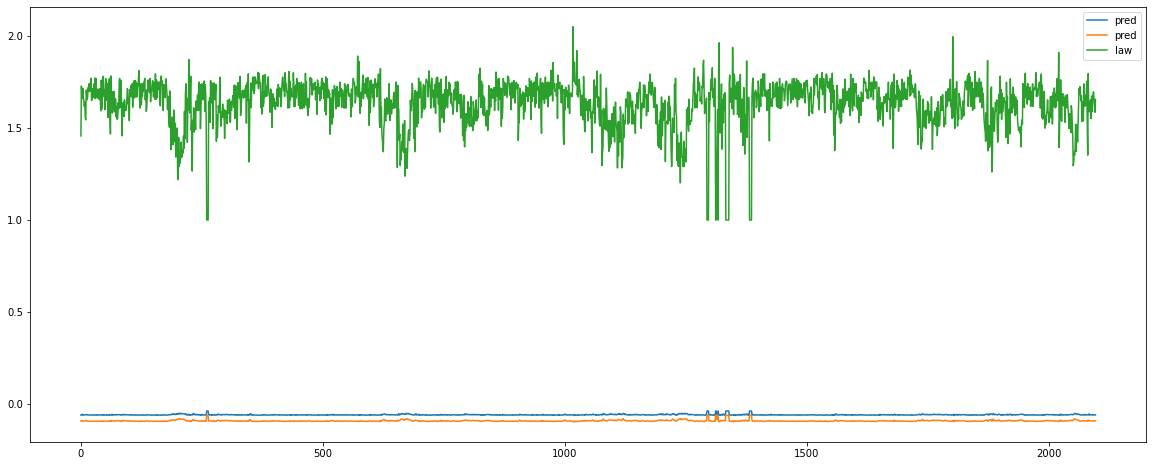

Epoch 4 / 20
[[-0.03162472 -0.06233222]
 [-0.02996909 -0.06042232]
 [-0.03014739 -0.06085138]
 ...
 [-0.03056951 -0.06298217]
 [-0.03077289 -0.0621572 ]
 [-0.03026308 -0.0614307 ]]


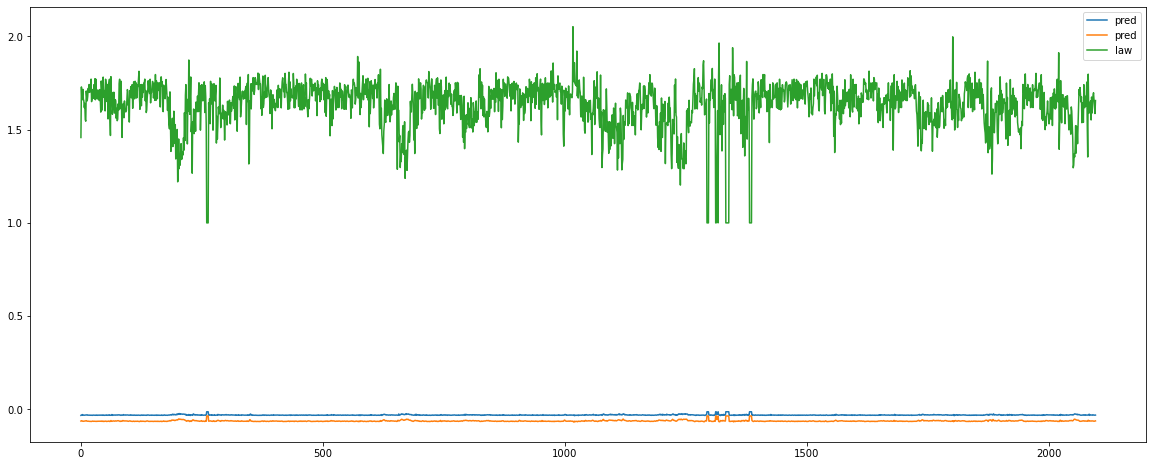

Epoch 5 / 20
[[-0.0038093  -0.03609375]
 [-0.00244136 -0.03444921]
 [-0.0025872  -0.03479667]
 ...
 [-0.00285271 -0.03671133]
 [-0.00307553 -0.03596908]
 [-0.00266428 -0.03533488]]


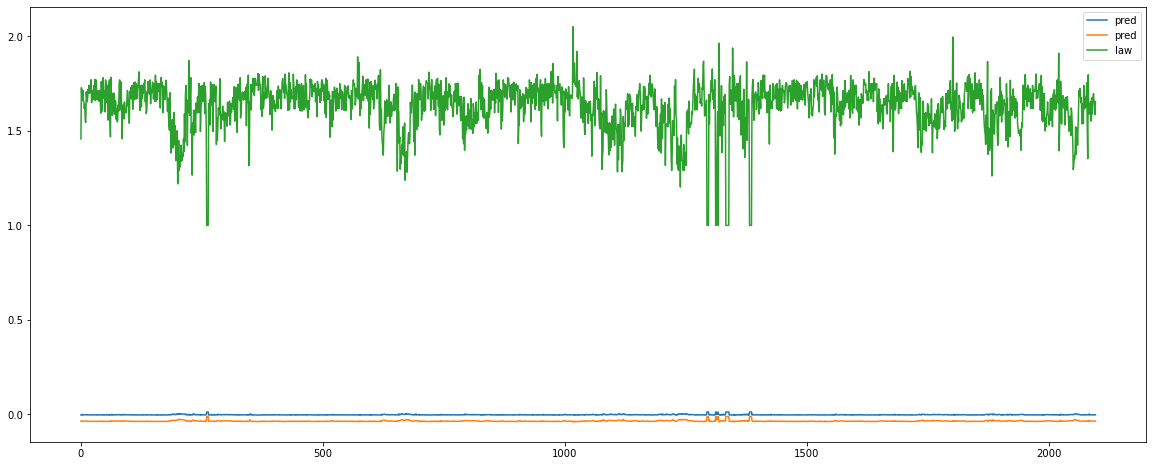

Epoch 6 / 20
[[ 0.02292246 -0.01334205]
 [ 0.02404777 -0.01190304]
 [ 0.02392488 -0.01218653]
 ...
 [ 0.02379516 -0.01392742]
 [ 0.02355635 -0.01325292]
 [ 0.02388383 -0.01269067]]


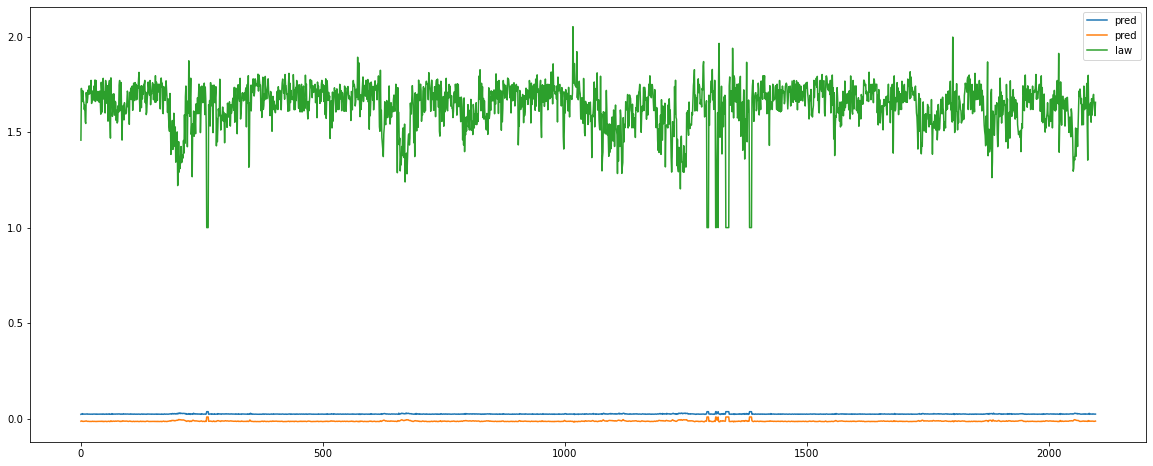

Epoch 7 / 20
[[0.04893876 0.00669223]
 [0.04985841 0.00797124]
 [0.04975159 0.00773877]
 ...
 [0.04974057 0.00613747]
 [0.04948807 0.00675653]
 [0.04974407 0.0072624 ]]


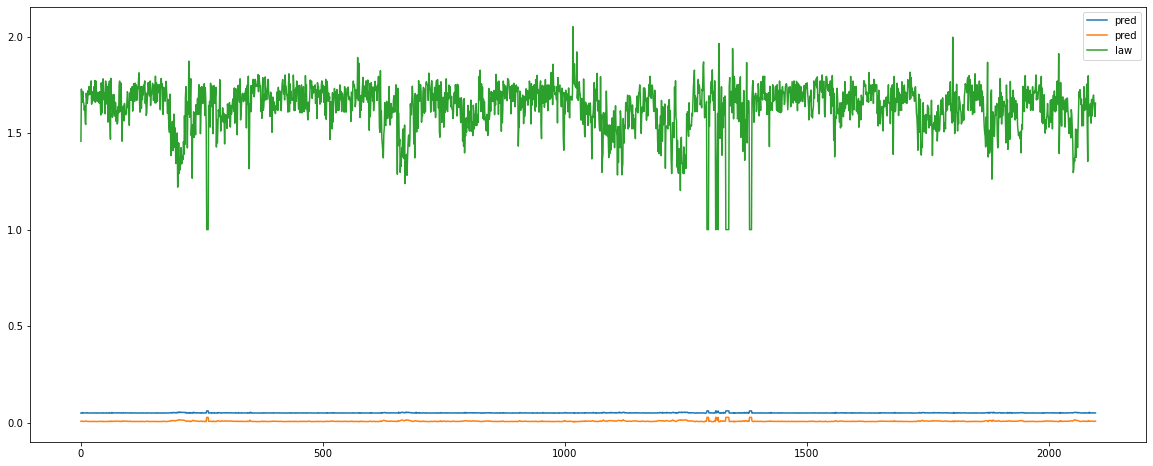

Epoch 8 / 20
[[0.07464419 0.024597  ]
 [0.07538815 0.02575166]
 [0.07529257 0.02556093]
 ...
 [0.07538667 0.02407109]
 [0.07512189 0.02464462]
 [0.0753164  0.02510648]]


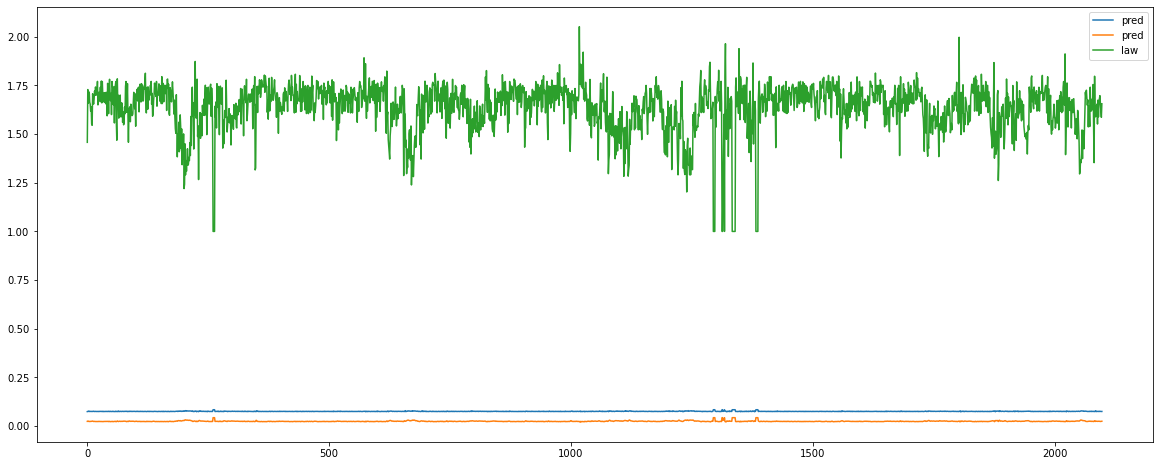

Epoch 9 / 20
[[0.10028929 0.04104037]
 [0.10088226 0.04209869]
 [0.10079449 0.04194329]
 ...
 [0.10098261 0.04054201]
 [0.10070632 0.04107783]
 [0.10084765 0.0415056 ]]


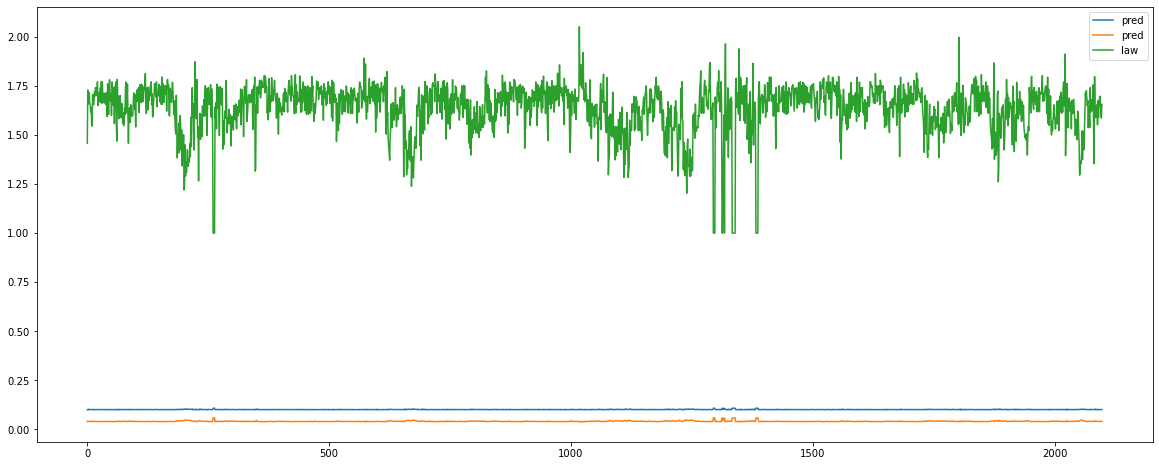

Epoch 10 / 20
[[0.12606865 0.05659307]
 [0.12653129 0.05757789]
 [0.12644918 0.05745361]
 ...
 [0.12672192 0.05612177]
 [0.12643455 0.05662613]
 [0.12652968 0.05702796]]


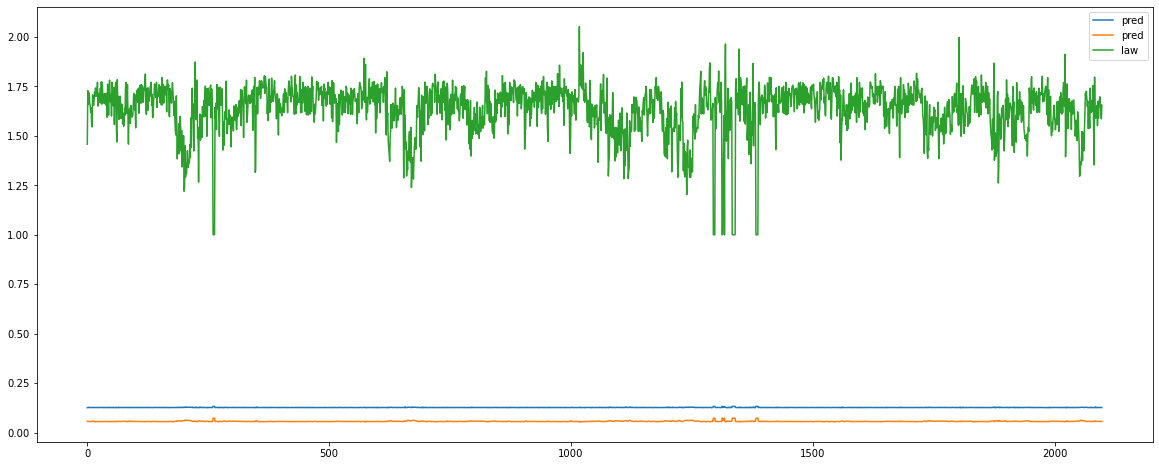

Epoch 11 / 20
[[0.15219544 0.07166845]
 [0.15254527 0.07259906]
 [0.15246767 0.07250328]
 ...
 [0.15281703 0.07122433]
 [0.15251866 0.07170232]
 [0.15257359 0.07208532]]


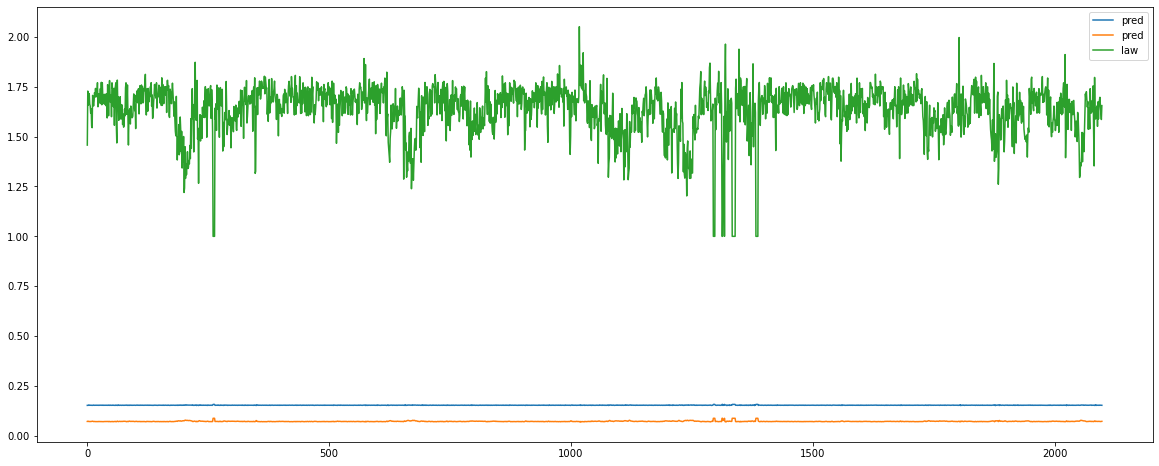

Epoch 12 / 20
[[0.17879392 0.08663308]
 [0.17904633 0.08752625]
 [0.17897296 0.0874575 ]
 ...
 [0.17939177 0.08621687]
 [0.17908227 0.08667274]
 [0.17910238 0.08704314]]


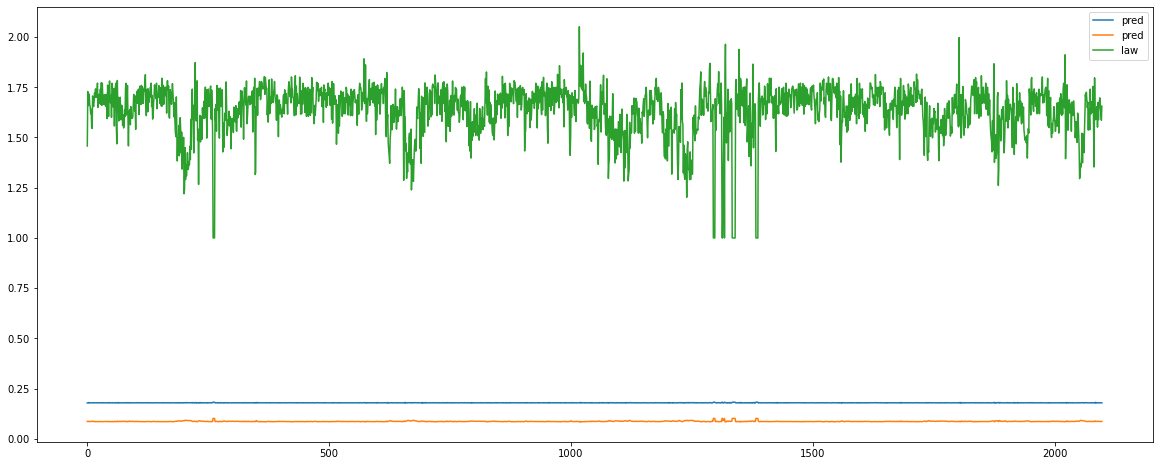

Epoch 13 / 20
[[0.2058909  0.10183697]
 [0.20606008 0.10270728]
 [0.20599136 0.10266492]
 ...
 [0.20647278 0.10144974]
 [0.20615186 0.101887  ]
 [0.20614216 0.10225043]]


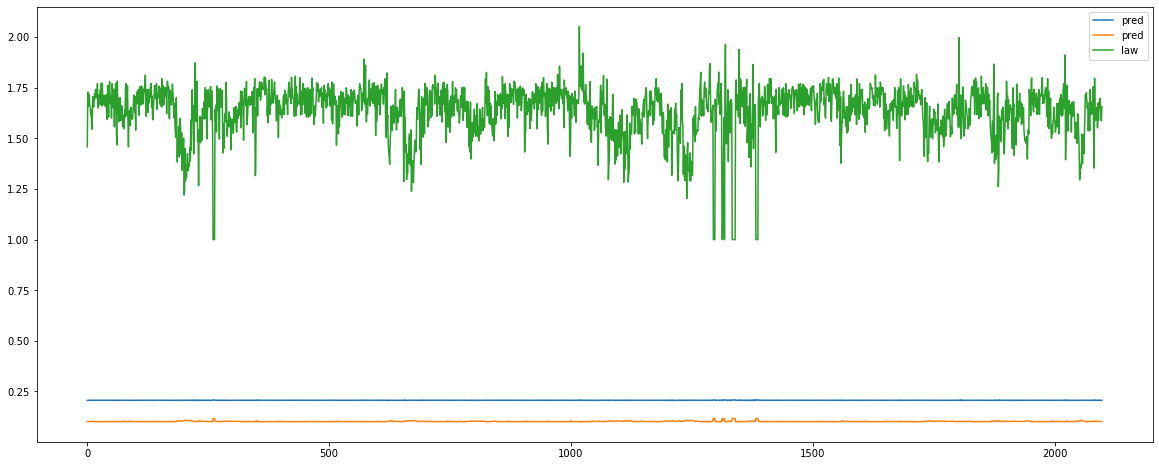

Epoch 14 / 20
[[0.2336368  0.11741968]
 [0.23373577 0.11828037]
 [0.23367292 0.11826421]
 ...
 [0.23421073 0.11706256]
 [0.23387775 0.11748445]
 [0.233843   0.11784597]]


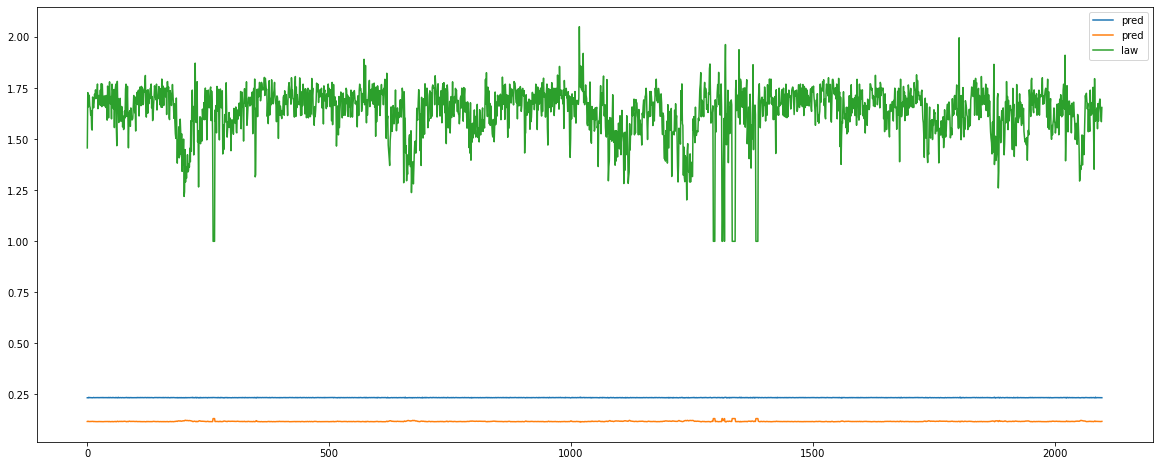

Epoch 15 / 20
[[0.2620927  0.13352467]
 [0.26206046 0.13436285]
 [0.26207906 0.13439798]
 ...
 [0.2626673  0.1331988 ]
 [0.26231688 0.13360664]
 [0.2622488  0.13396662]]


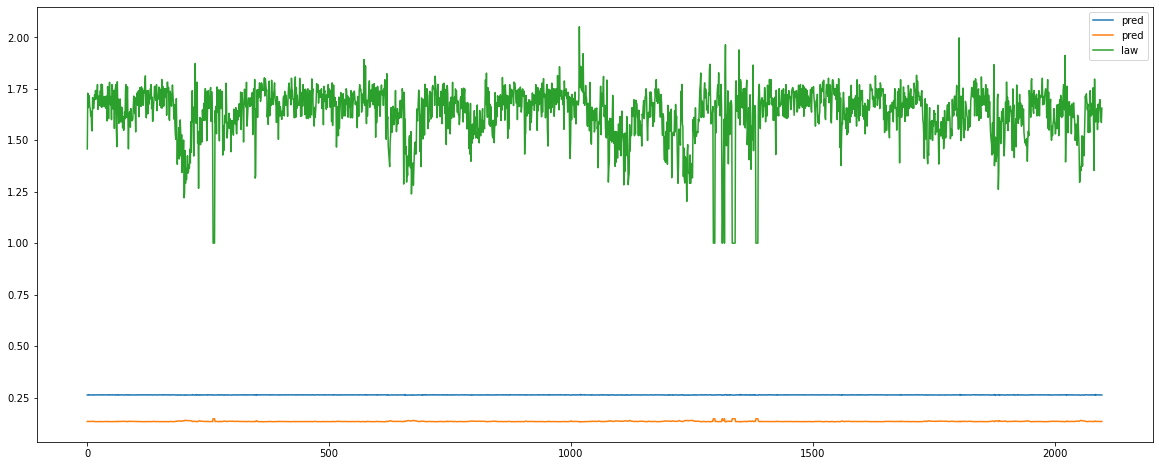

Epoch 16 / 20
[[0.2910834  0.15028946]
 [0.29097706 0.15112984]
 [0.2910049  0.151083  ]
 ...
 [0.2916656  0.15000024]
 [0.2912894  0.15039155]
 [0.29119477 0.15074687]]


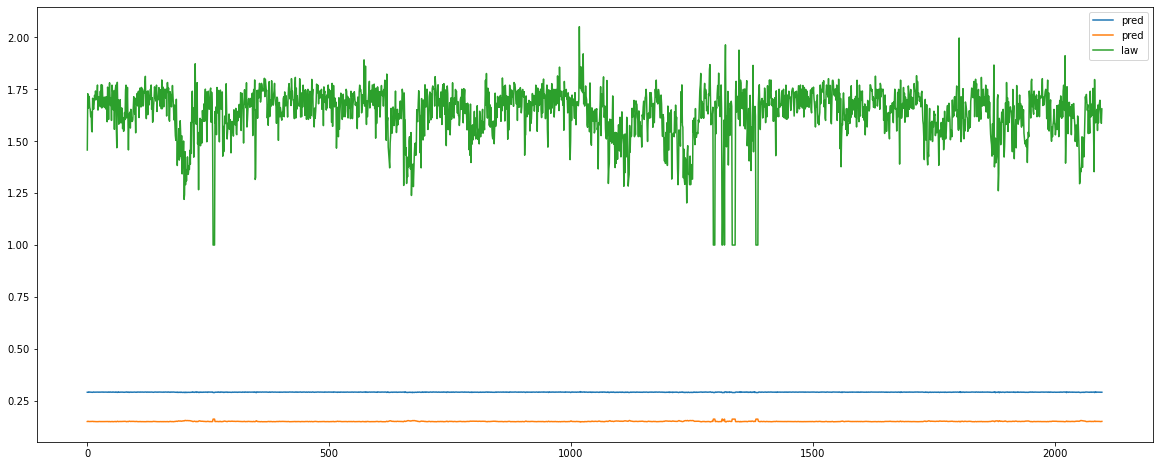

Epoch 17 / 20
[[0.3206867  0.16736346]
 [0.32051933 0.16795947]
 [0.32056183 0.1678665 ]
 ...
 [0.32130128 0.1669715 ]
 [0.32089007 0.16733855]
 [0.32076973 0.16758807]]


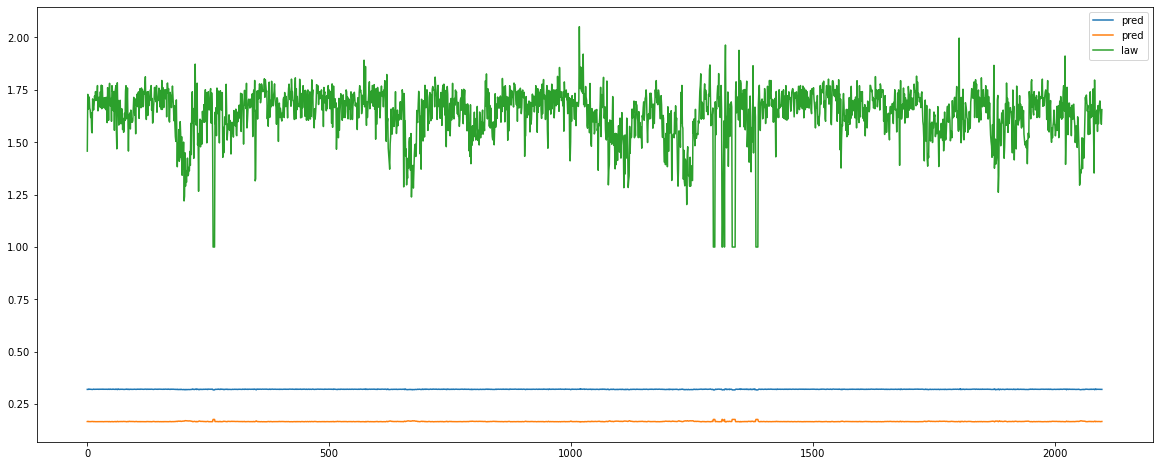

Epoch 18 / 20
[[0.3509911  0.18437219]
 [0.35075474 0.18493503]
 [0.35080987 0.18484274]
 ...
 [0.35162073 0.1839816 ]
 [0.35118568 0.18433936]
 [0.35104007 0.18457587]]


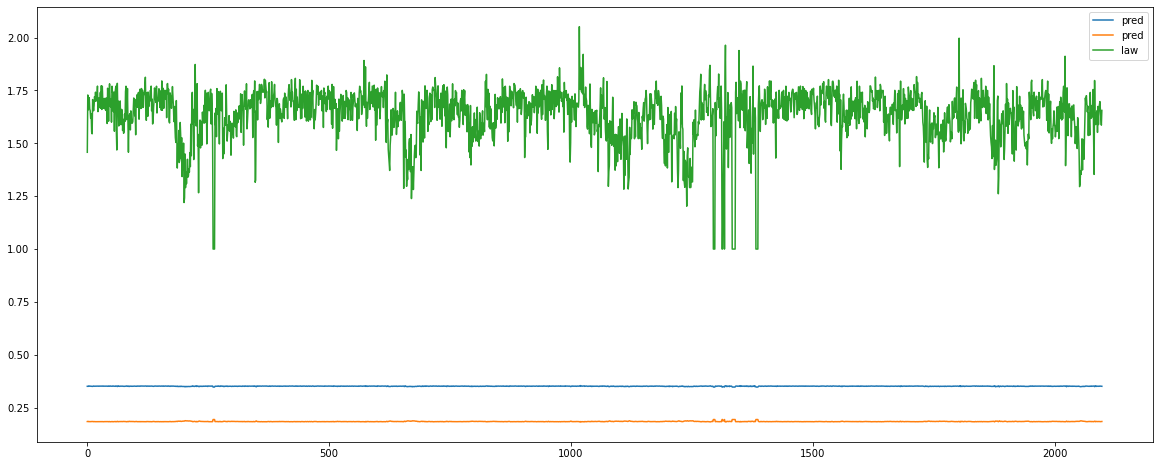

Epoch 19 / 20
[[0.38200998 0.20223562]
 [0.38170868 0.20276648]
 [0.38177925 0.20267302]
 ...
 [0.38266277 0.20184332]
 [0.38220078 0.20219368]
 [0.38203144 0.20241755]]


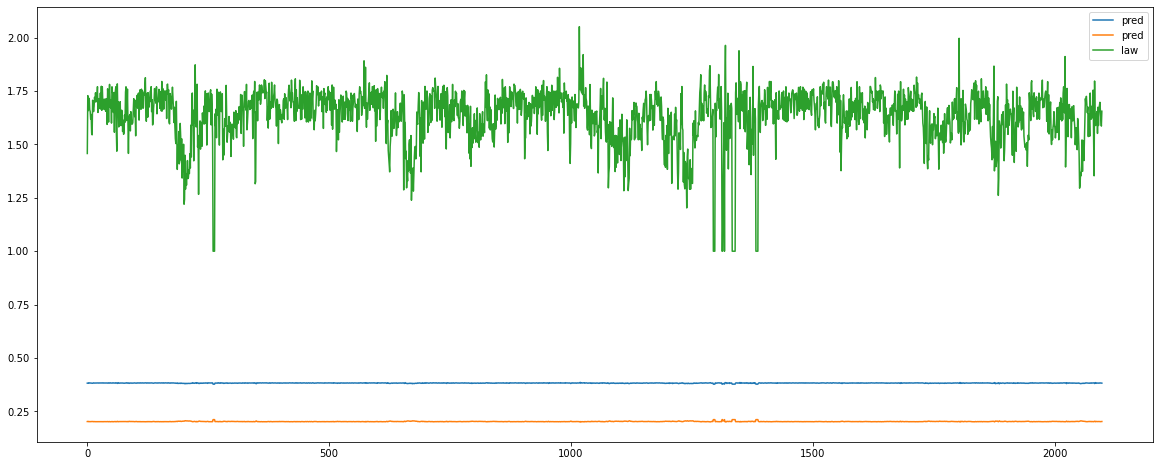

Epoch 20 / 20
[[0.41382676 0.22096714]
 [0.41346312 0.22146708]
 [0.41355258 0.22137079]
 ...
 [0.41451144 0.2205705 ]
 [0.4140187  0.22091508]
 [0.41382658 0.22112668]]


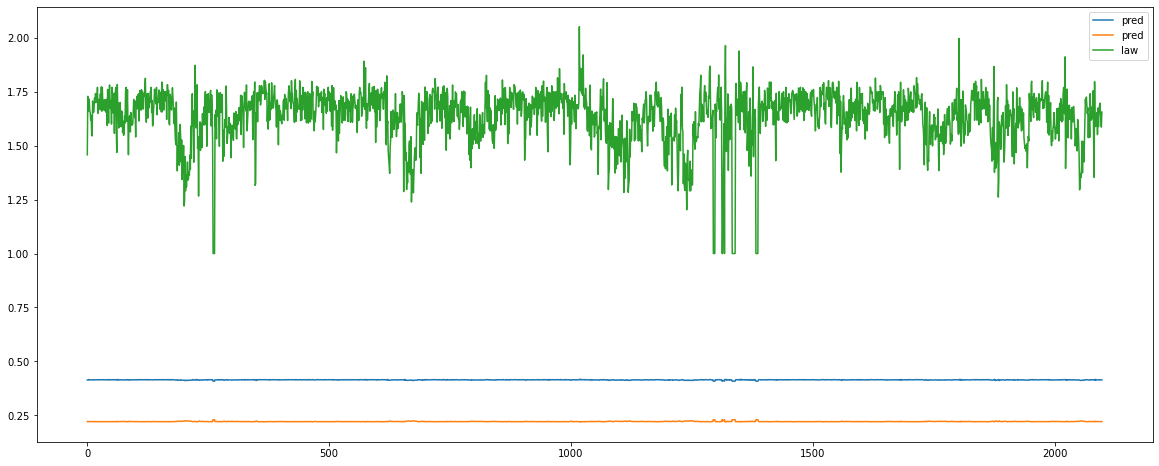

In [10]:
epochs=20
model_stateful = model

for i in range(epochs): 
    
    model_stateful.fit(r_x_train, y_train, batch_size = 1024, epochs = 1, verbose = 0, validation_split=0.1, validation_data=(r_x_train, r_y_train))

    if i % 1 == 0:        
        print('Epoch', i + 1, '/', epochs)
        pred_y=model_stateful.predict(r_x_valid)
        print(pred_y)      
        
        plt.figure(figsize=(20,8))        
        plt.plot(pred_y, label='pred')
        plt.plot(en_valid, label='law')

        plt.legend()
        plt.show()
        
   

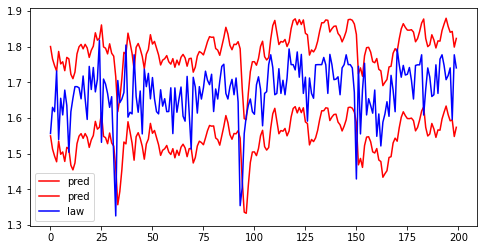

In [18]:
#model.fit(r_x_train, y_train, batch_size = 1024, epochs = 400, verbose = 0, validation_split=0.1, validation_data=(r_x_train, r_y_train))

pred_y=model.predict(r_x_valid, batch_size=1024)

'''
a=pred_y#[1000:1200]
b=en_valid#[1000:1200]
c=y_valid#[1000:1200]

'''
pred_y=model.predict(r_x_train, batch_size=1024)
a=pred_y[1000:1200]
b=en_train[1000:1200]
c=y_train[1000:1200]



b=b.reset_index(drop=True)
c=c.reset_index(drop=True)



plt.figure(figsize=(8,4))
plt.plot(a, label='pred', color='red')
plt.plot(b, label='law',color ='blue')
#plt.plot(c, label='train', color='purple')

#xx=list(range(len(a)))
#plt.fill_between(xx, c, color='lightgray', alpha=0.5)



plt.legend()
plt.show()